In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import re
import csv
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
from scipy.io import loadmat 
from pathlib import Path

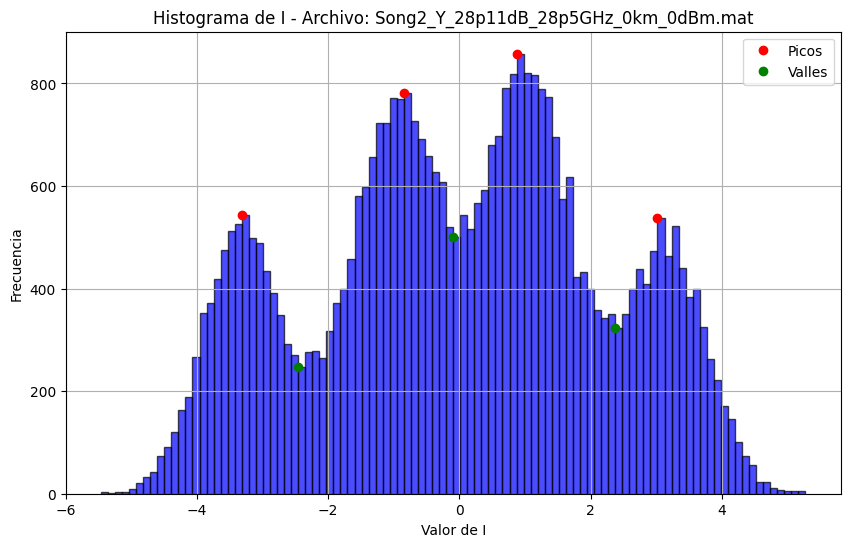

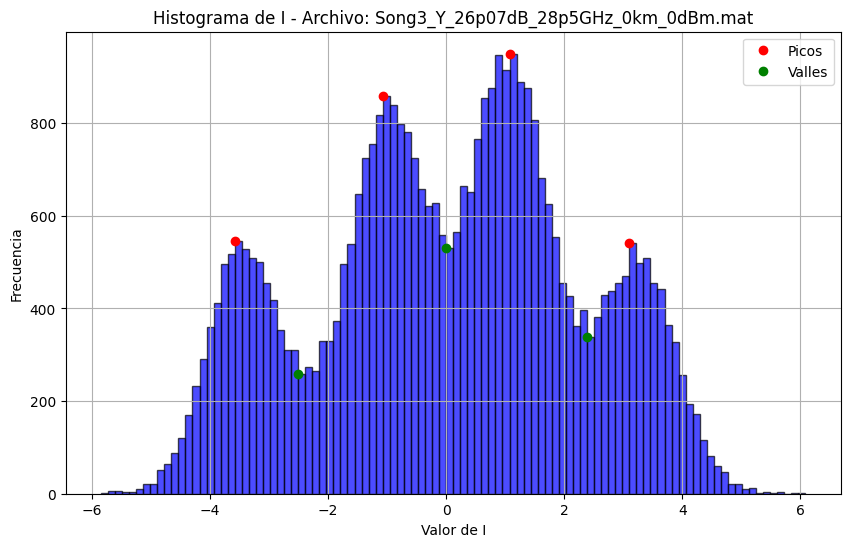

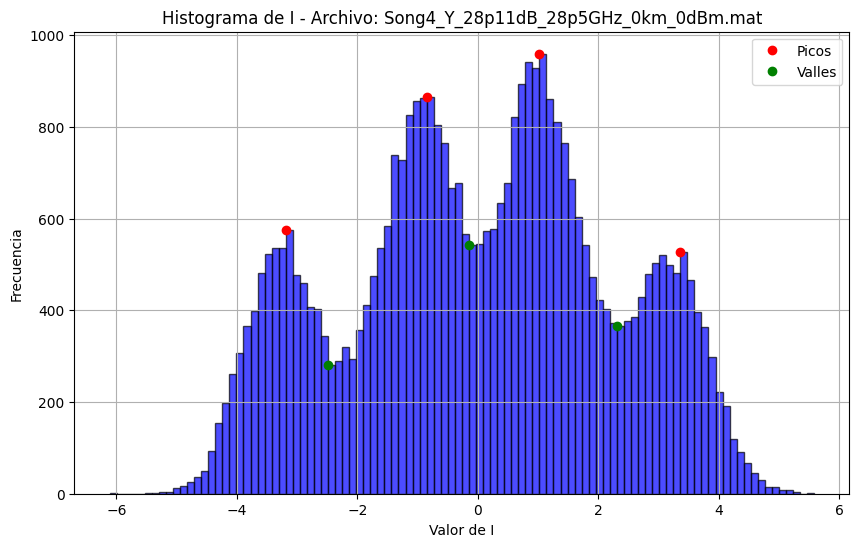

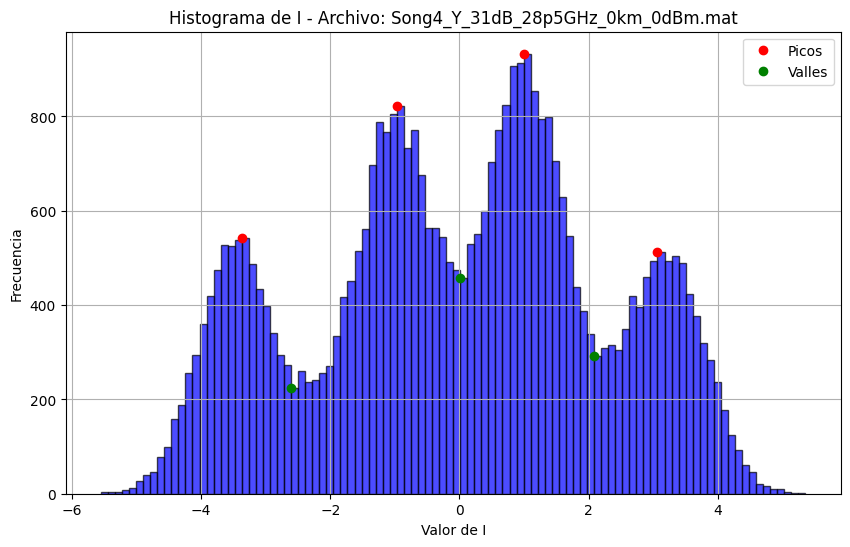

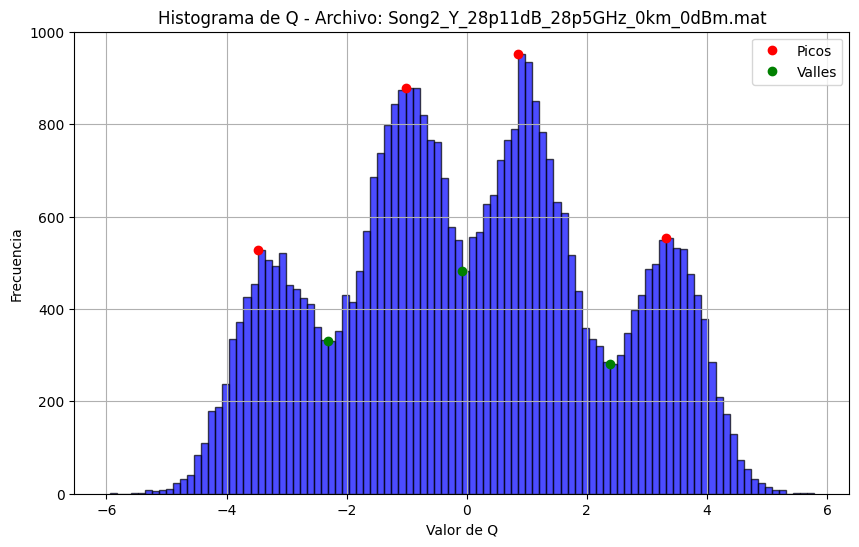

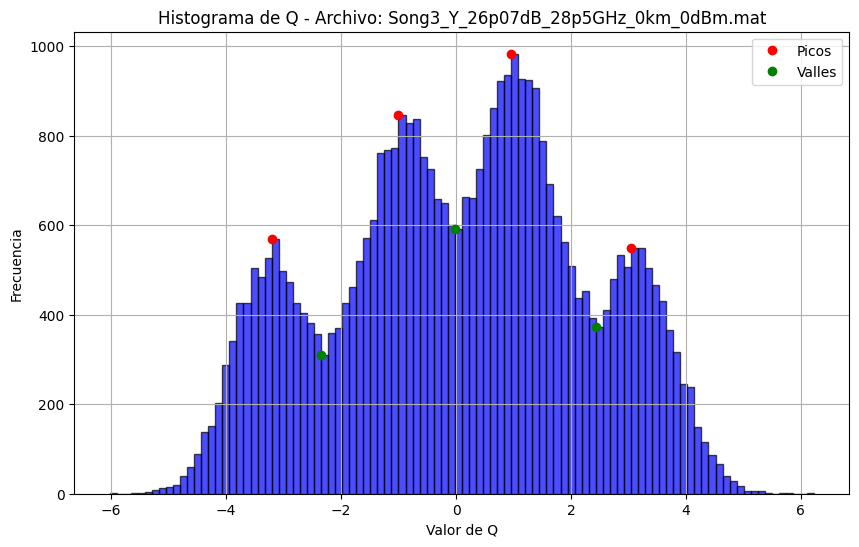

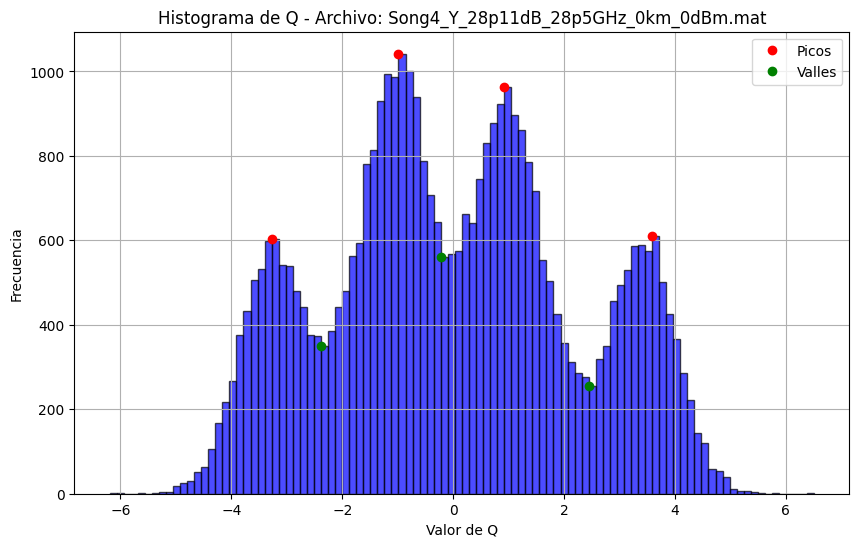

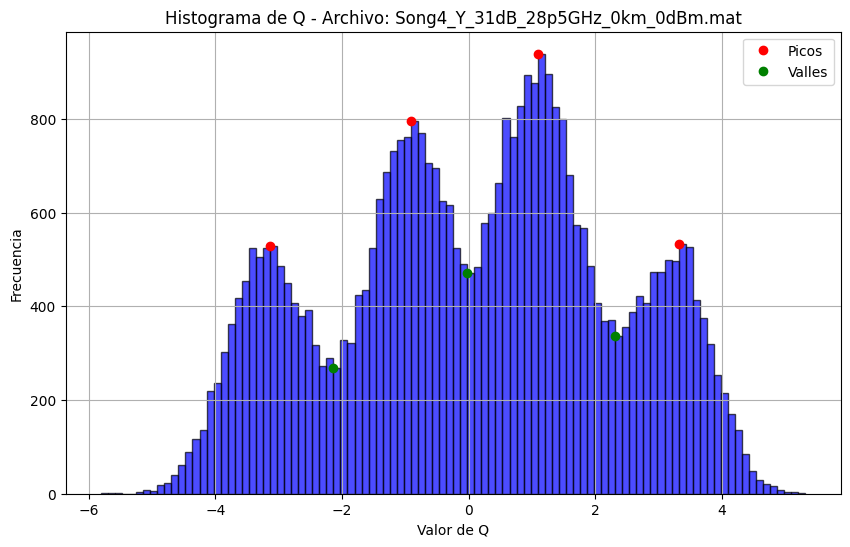

{'3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz_Song2_Y_28p11dB_28p5GHz_0km_0dBm.mat': {'peaks': array([-3.48374248, -1.01981233,  0.85746779,  3.32139795]),
  'valleys': array([-2.31044241, -0.08117227,  2.38275789]),
  'ensanchamiento': np.float64(11.733000739011015)},
 '3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz_Song3_Y_26p07dB_28p5GHz_0km_0dBm.mat': {'peaks': array([-3.20663919, -1.00044772,  0.96061137,  3.04423665]),
  'valleys': array([-2.34867584, -0.01991817,  2.43140568]),
  'ensanchamiento': np.float64(12.256619287551715)},
 '3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz_Song4_Y_28p11dB_28p5GHz_0km_0dBm.mat': {'peaks': array([-3.2726488 , -0.98524327,  0.92092801,  3.58956779]),
  'valleys': array([-2.3831022 , -0.22277476,  2.44586503]),
  'ensanchamiento': np.float64(12.707808498589797)},
 '3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz_Song4_Y_31dB_28p5GHz_0km_0dBm.mat': {'peaks': array([-3.13737164, -0.91123359,  1.09229067,  3.31842872]),
  'valleys': array([-2.13560952, -0.02077836,  2.3166666 ]),
  'e

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Leer los datos de los archivos .mat en la carpeta específica
def read_csv_data(main_folder_path):
    data = {}

    # Ruta específica que queremos procesar
    specific_path = os.path.join(main_folder_path, "3x32Gbaud_16QAM", "0km_0dBm", "28p5GHz")

    # Verifica si la ruta específica existe
    if os.path.exists(specific_path) and os.path.isdir(specific_path):
        key_path = "3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz"
        data[key_path] = []

        # Procesa solo los archivos en la carpeta especificada (Nivel 3)
        for filename in os.listdir(specific_path):
            # Solo procesa archivos con extensión .mat
            if filename.endswith(".mat"):
                file_path = os.path.join(specific_path, filename)

                # Lee el archivo .mat y convierte los datos a un DataFrame
                mat_data = loadmat(file_path)
                if "rconst" in mat_data:
                    df = mat_data["rconst"][0]
                    df = pd.DataFrame({"I": df.real, "Q": df.imag})

                    # Añade una tupla (nombre del archivo, DataFrame) a la lista
                    data[key_path].append((filename, df))
                else:
                    print(f"Advertencia: 'rconst' no encontrado en el archivo {filename}")
    else:
        print(f"La ruta específica '{specific_path}' no existe o no es válida.")
    
    return data

# Encontrar picos en un segmento
def find_peak_in_segment(counts, bin_edges, start, end):
    start_idx = np.searchsorted(bin_edges, start, side='left')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    if start_idx >= end_idx or start_idx >= len(counts):
        return None  # Segmento vacío o fuera de límites

    peak_idx = start_idx + np.argmax(counts[start_idx:end_idx])
    return peak_idx

# Encontrar valles en un segmento
def find_valley_in_segment(counts, bin_edges, start, end):
    start_idx = np.searchsorted(bin_edges, start, side='right')
    end_idx = np.searchsorted(bin_edges, end, side='left')

    if start_idx >= end_idx or start_idx >= len(counts):
        return None  # Segmento vacío o fuera de límites

    valley_idx = start_idx + np.argmin(counts[start_idx:end_idx])
    return valley_idx

# Generar los histogramas para una subcarpeta específica
def plot_histograms_for_specific_subfolder(data, var_name):
    key_path = "3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz"
    results_all = {}

    # Verifica que la subcarpeta específica exista en los datos
    if key_path not in data:
        print(f"La subcarpeta '{key_path}' no existe en los datos.")
        return results_all

    files = data[key_path]

    # Procesa cada archivo en la subcarpeta específica
    for item in files:
        if len(item) != 2:
            print(f"Error: se esperaba una tupla con 2 elementos, pero se encontró: {item}")
            continue

        filename, df = item
        
        # Obtén los datos del histograma
        counts, bin_edges = np.histogram(df[var_name], bins=100)
        
        # Encontrar el pico más alto en cada segmento
        peaks = [
            find_peak_in_segment(counts, bin_edges, -4, -2),
            find_peak_in_segment(counts, bin_edges, -2, 0),
            find_peak_in_segment(counts, bin_edges, 0, 2),
            find_peak_in_segment(counts, bin_edges, 2, 4)
        ]
        
        # Encontrar el valle más bajo en cada segmento
        valleys = [
            find_valley_in_segment(counts, bin_edges, -3, -1),
            find_valley_in_segment(counts, bin_edges, -1, 1),
            find_valley_in_segment(counts, bin_edges, 1, 3)
        ]
        
        # Filtrar valores None
        peaks = [peak for peak in peaks if peak is not None]
        valleys = [valley for valley in valleys if valley is not None]
        
        # Guardar los resultados
        peaks_bin_edges = bin_edges[peaks]
        valleys_bin_edges = bin_edges[valleys]
        ensanchamiento = bin_edges[-1] - bin_edges[0]

        results_all[f'{key_path}_{filename}'] = {
            'peaks': peaks_bin_edges,
            'valleys': valleys_bin_edges,
            'ensanchamiento': ensanchamiento
        }
        
        # Graficar el histograma
        plt.figure(figsize=(10, 6))
        plt.hist(df[var_name], bins=100, alpha=0.7, color='blue', edgecolor='black')
        plt.plot(bin_edges[peaks], counts[peaks], 'ro', label='Picos')
        plt.plot(bin_edges[valleys], counts[valleys], 'go', label='Valles')
        plt.title(f'Histograma de {var_name} - Archivo: {filename}')
        plt.xlabel(f'Valor de {var_name}')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.grid(True)
        plt.show()

    return results_all

# Ruta principal y ejecución
main_folder_path = "/Users/USUARIO/Documents/ProyectoJames"
data = read_csv_data(main_folder_path)

plot_histograms_for_specific_subfolder(data, var_name="I")

plot_histograms_for_specific_subfolder(data, var_name="Q")



#if data:
    #plot_histograms_for_specific_subfolder(data, var_name="I")


In [6]:
print(data.items())

dict_items([('3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz', [('Song2_Y_28p11dB_28p5GHz_0km_0dBm.mat',               I         Q
0     -3.620020  3.221106
1      3.886321  1.629083
2      3.715104  3.970738
3     -0.802521 -4.227192
4      2.600286 -0.549269
...         ...       ...
39526  3.107871  0.808279
39527  1.051099 -1.484517
39528 -0.692446 -1.286135
39529  0.878934 -3.315101
39530  1.013196  1.001196

[39531 rows x 2 columns]), ('Song3_Y_26p07dB_28p5GHz_0km_0dBm.mat',               I         Q
0      0.844534 -1.244788
1      3.789840 -2.821729
2     -1.673740 -3.880104
3     -2.422620 -0.375730
4      0.312947  2.912408
...         ...       ...
39526 -1.759612  2.525436
39527 -0.610439  0.579856
39528  0.951177 -3.559550
39529  3.667480  4.443502
39530  3.812584  3.989728

[39531 rows x 2 columns]), ('Song4_Y_28p11dB_28p5GHz_0km_0dBm.mat',               I         Q
0     -0.725513  0.770507
1     -3.734069 -0.771531
2     -2.669921 -4.077023
3     -0.265249 -1.822847
4      0.1345

In [7]:
#funciona más o menos
def analyze_data(data):
    pattern = r'(\d+(\.\d+)?)GHz'
    pattern_osnr = r'(\d+(\.\d+)?)(?=dB(?!m))'
    

    matriz_caract = np.empty((0, 18))  # Inicializa la matriz vacía
    count = 0  # Contador para limitar a 3 histogramas

    for subfolder1, archivos in data.items():  # Iterar sobre cada carpeta de nivel 1
        print(f'Se está leyendo la carpeta de nivel 1: {subfolder1}')
        
        if 'dBm' in subfolder1:  # Verificar que la carpeta tenga 'dBm'
            print(f'Procesando carpeta: {subfolder1}')
            
            for filename, df in archivos:  # Iterar sobre archivos en la lista de la carpeta
                print(f'Archivo encontrado: {filename}')
                
                match = re.search(pattern, subfolder1.replace('p','.'))  # Extraer GHz desde el nombre de la carpeta
                spacing = float(match.group(1)) if match else None

                resultsI = plot_histograms_for_specific_subfolder(data, var_name="I")
                
                resultsQ = plot_histograms_for_specific_subfolder(data, var_name="Q")
                
                for resultI, resultQ in zip(resultsI.items(), resultsQ.items()):
                    match = re.search(pattern_osnr, resultI[0].replace('p','.'))
                    OSNR = float(match.group(1)) if match else None

                    I = resultI[1]
                    Q = resultQ[1]

                    vector = np.hstack((
                        I["peaks"], Q["peaks"],
                        I["valleys"], Q["valleys"],
                        I["ensanchamiento"],
                        Q["ensanchamiento"],
                        [spacing, OSNR]
                    ))

                    matriz_caract = np.vstack((matriz_caract, vector))
                    count += 1  # Incrementa el contador
    return matriz_caract

Se está leyendo la carpeta de nivel 1: 3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz
Procesando carpeta: 3x32Gbaud_16QAM > 0km_0dBm > 28p5GHz
Archivo encontrado: Song2_Y_28p11dB_28p5GHz_0km_0dBm.mat


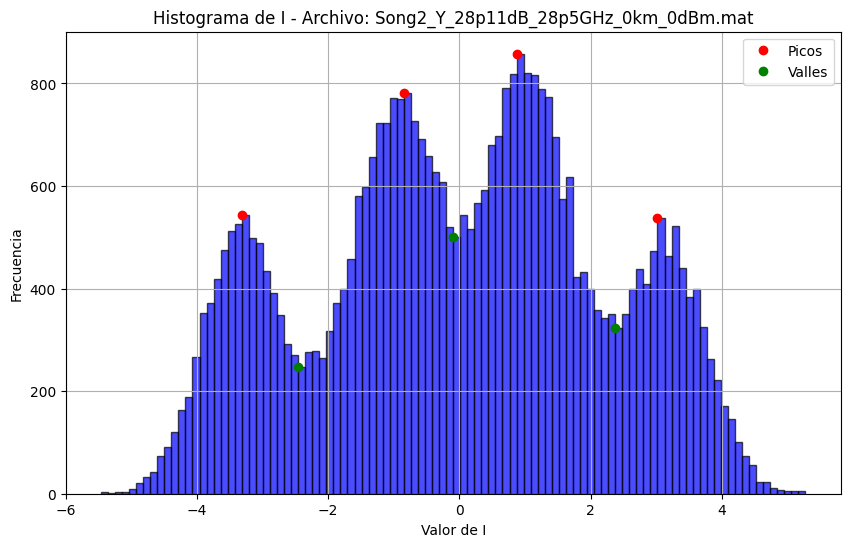

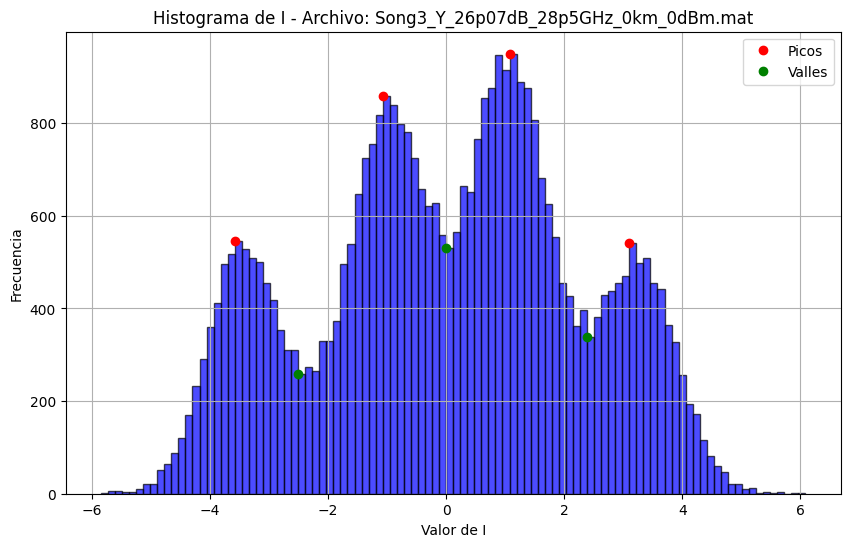

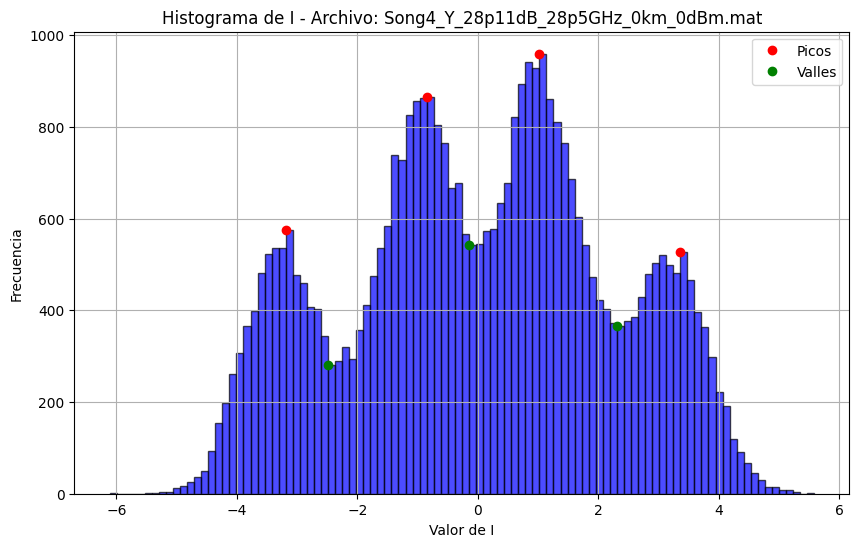

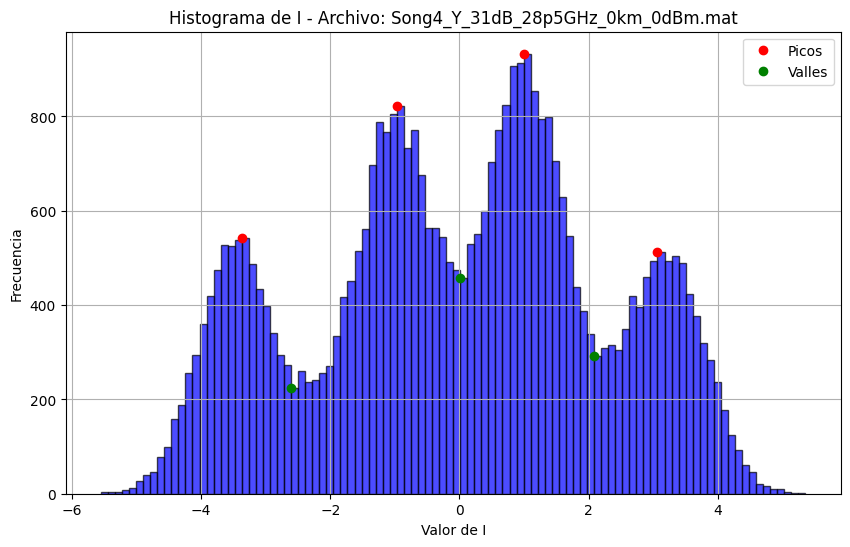

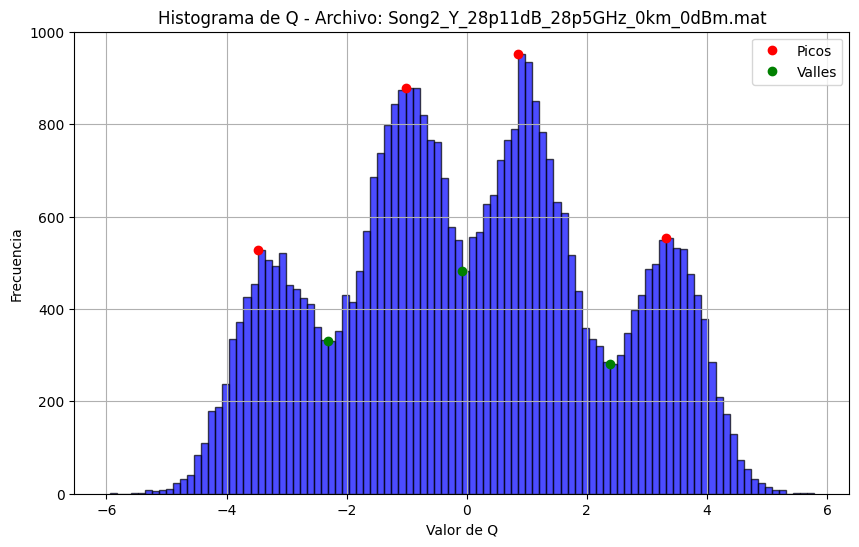

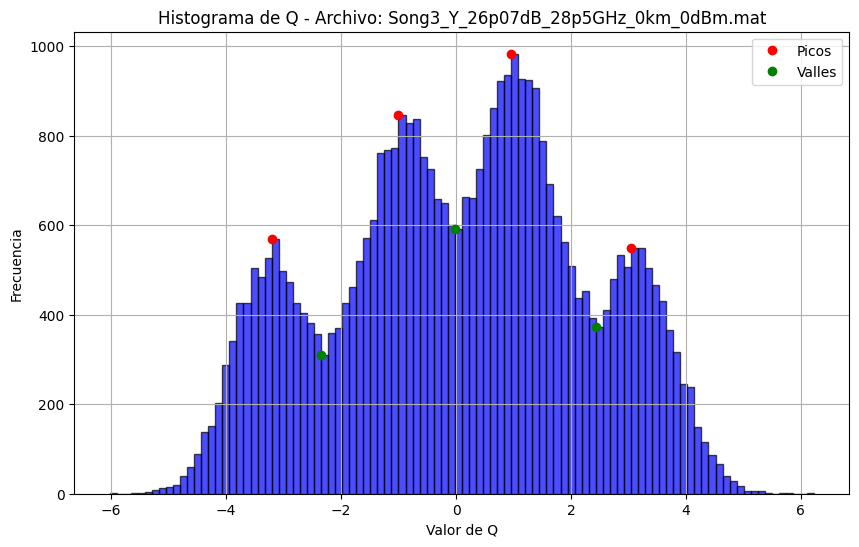

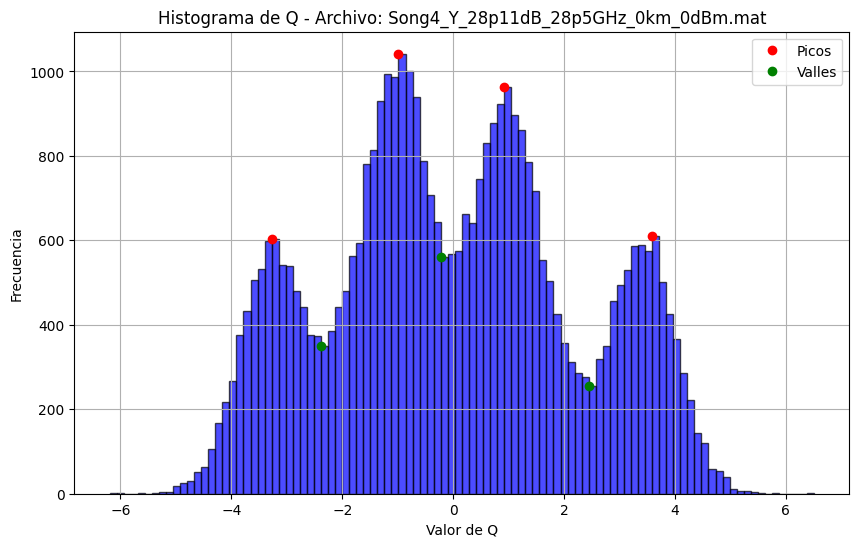

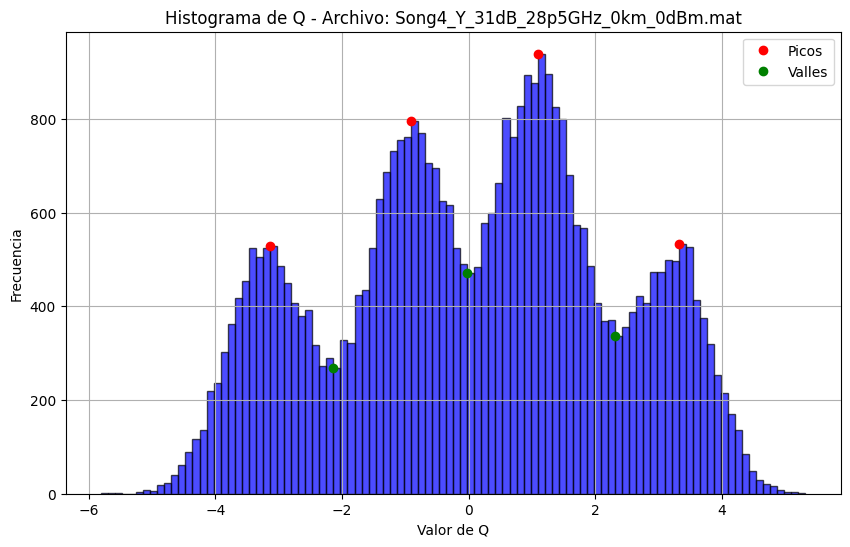

Archivo encontrado: Song3_Y_26p07dB_28p5GHz_0km_0dBm.mat


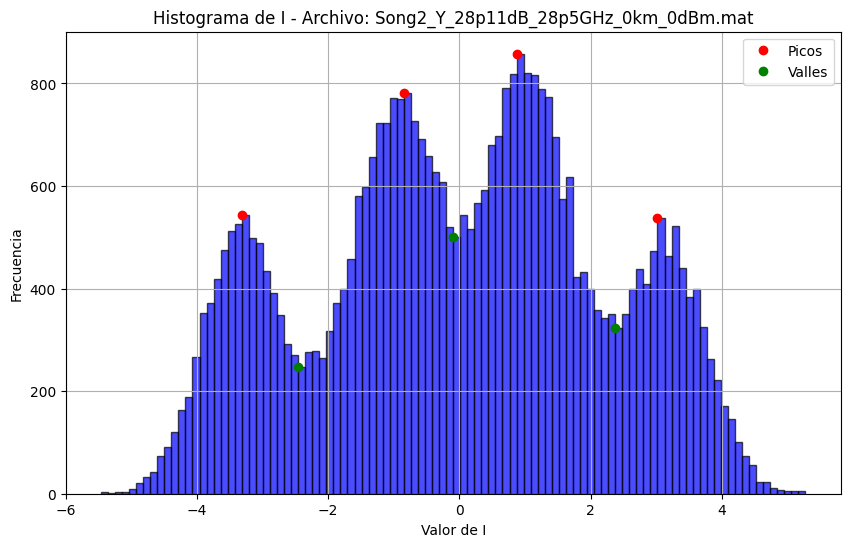

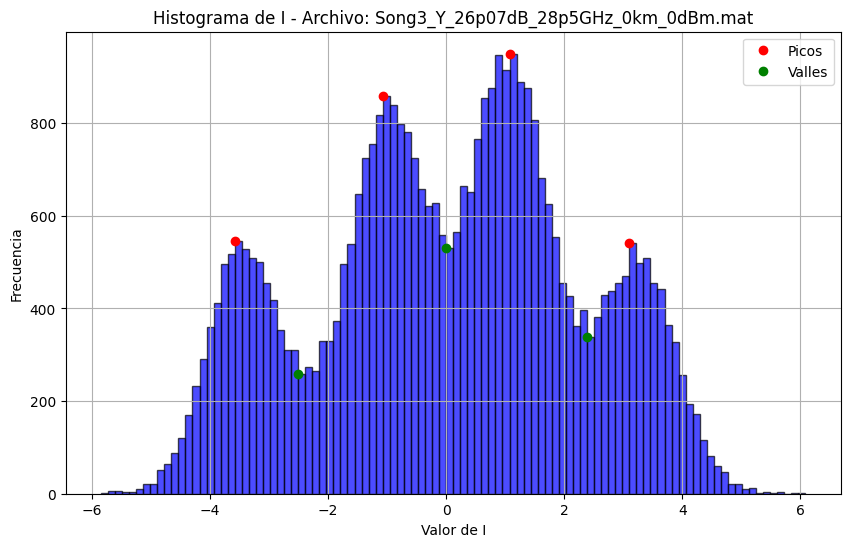

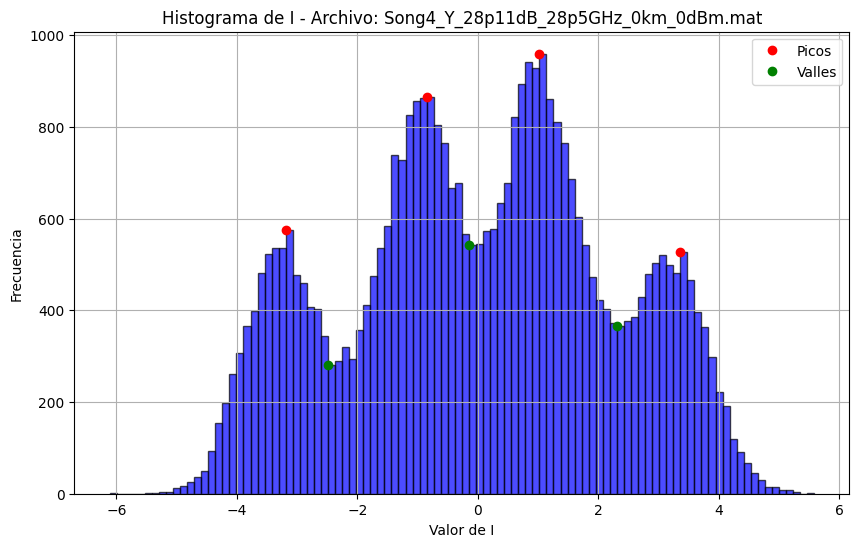

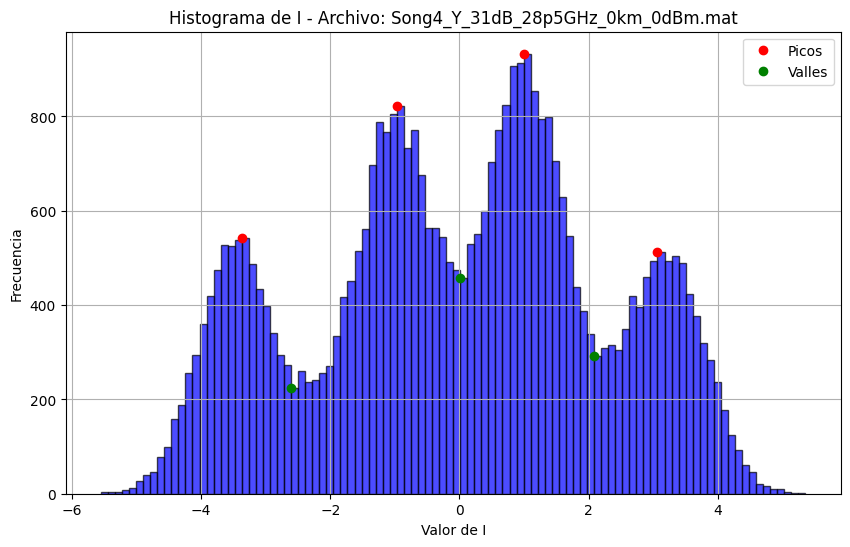

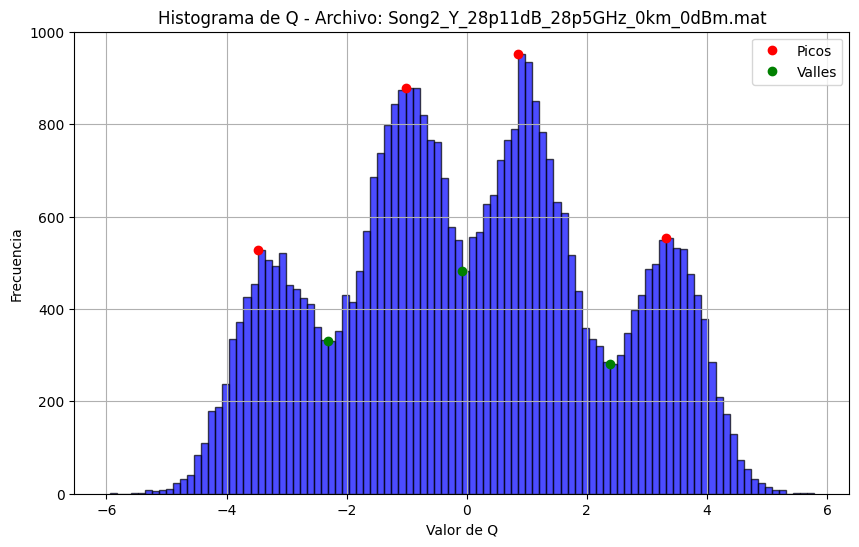

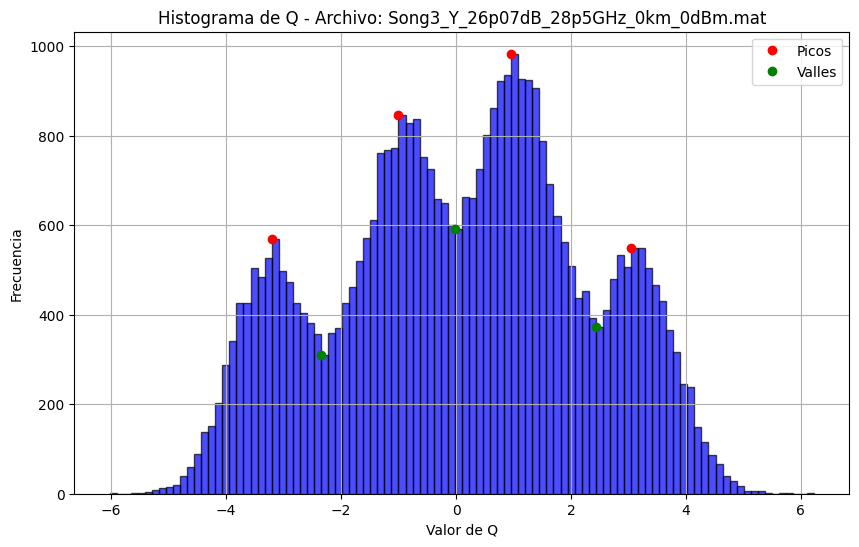

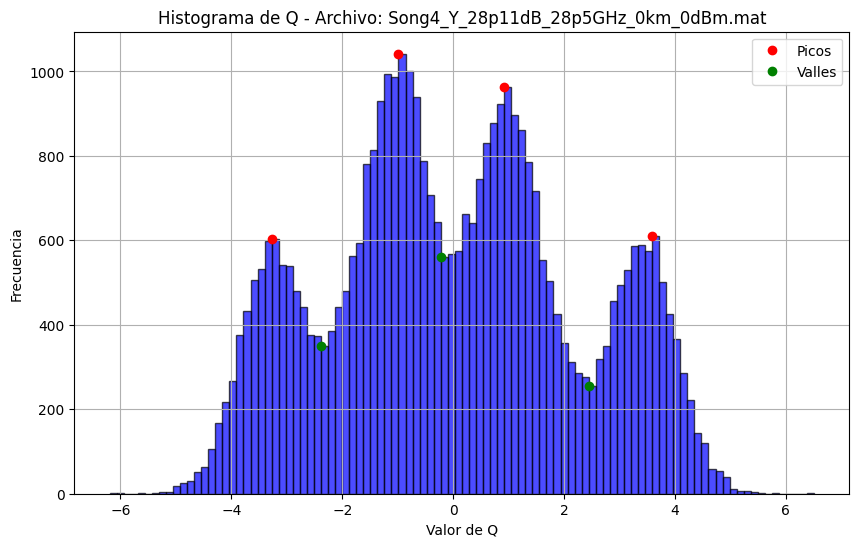

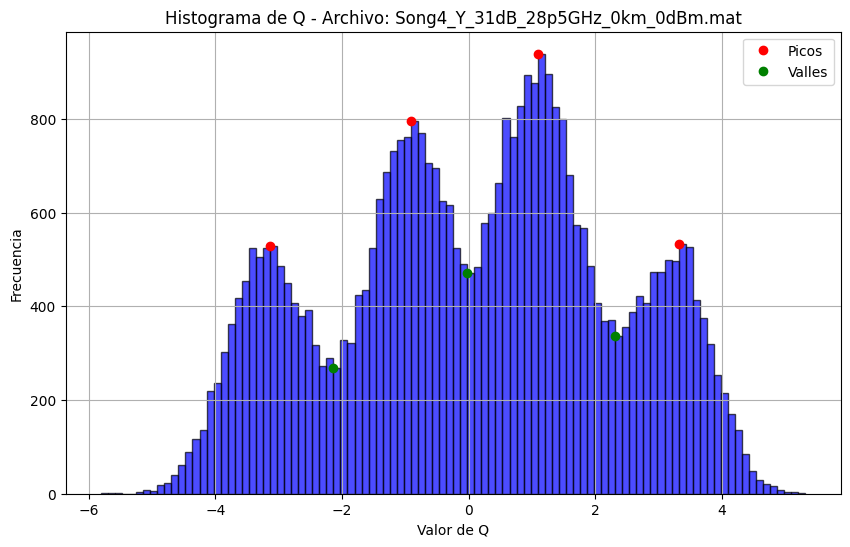

Archivo encontrado: Song4_Y_28p11dB_28p5GHz_0km_0dBm.mat


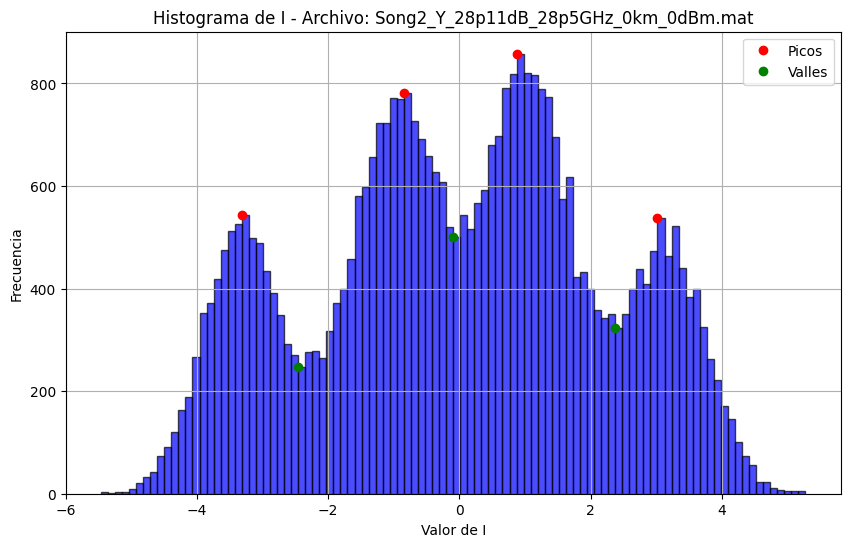

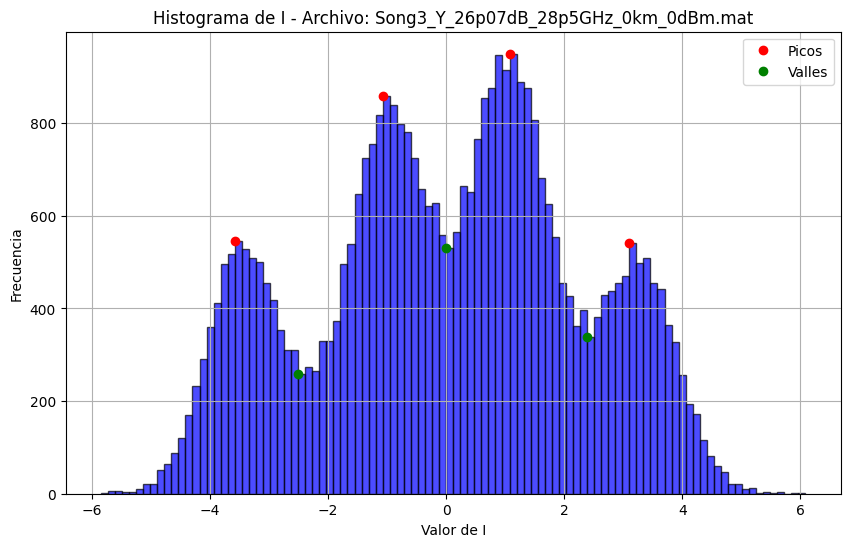

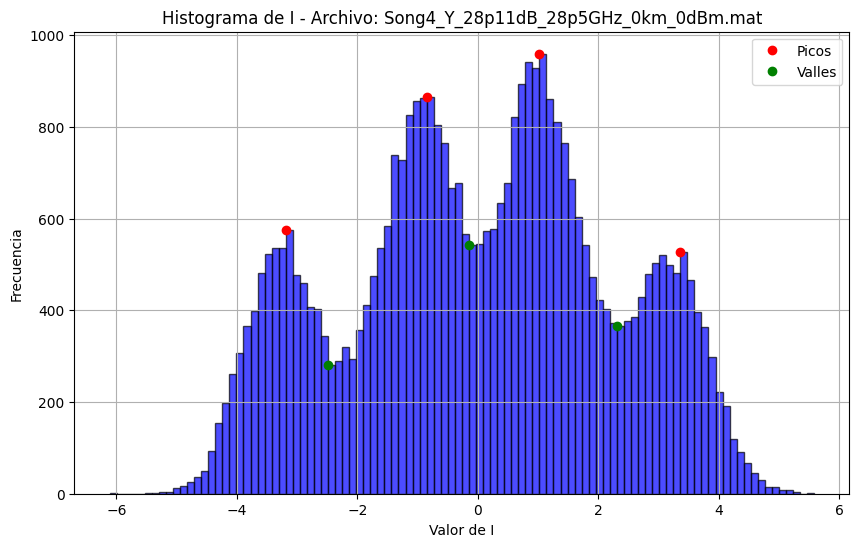

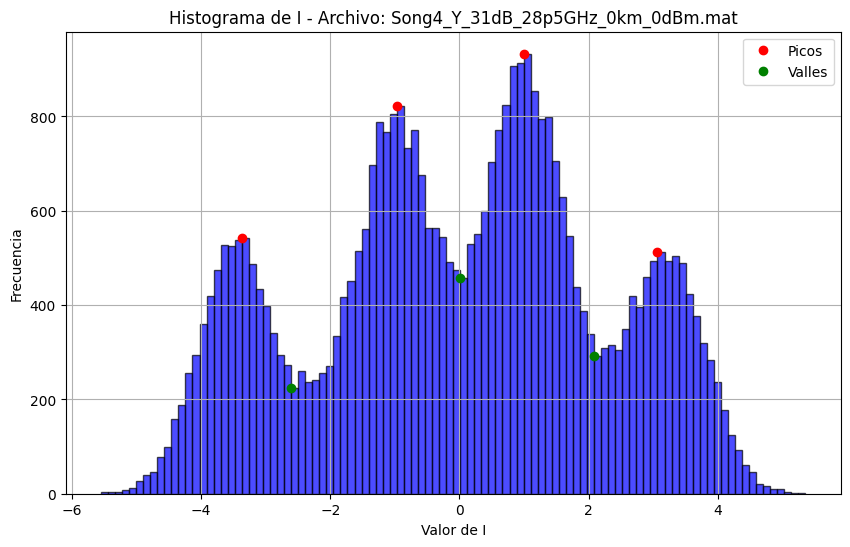

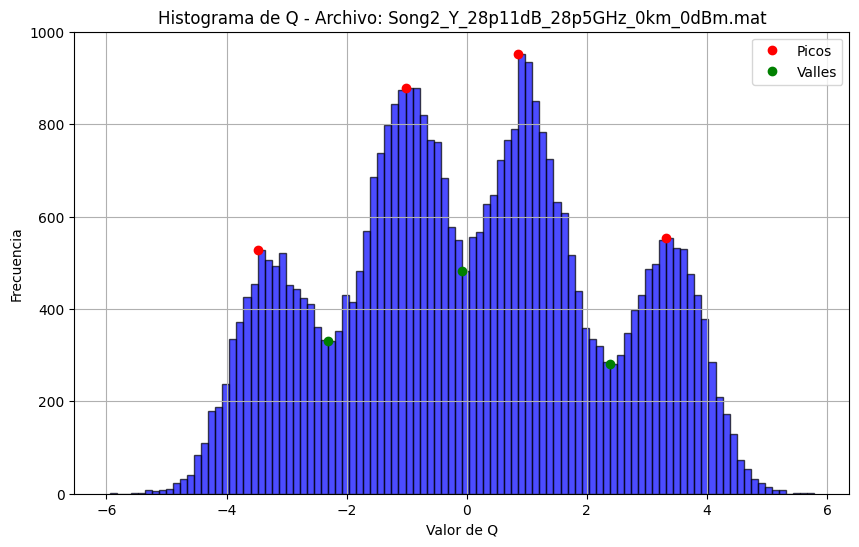

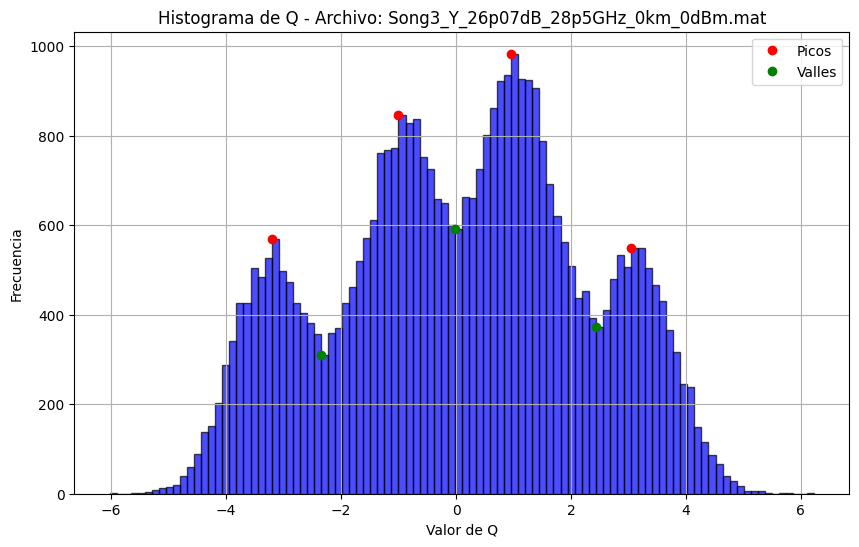

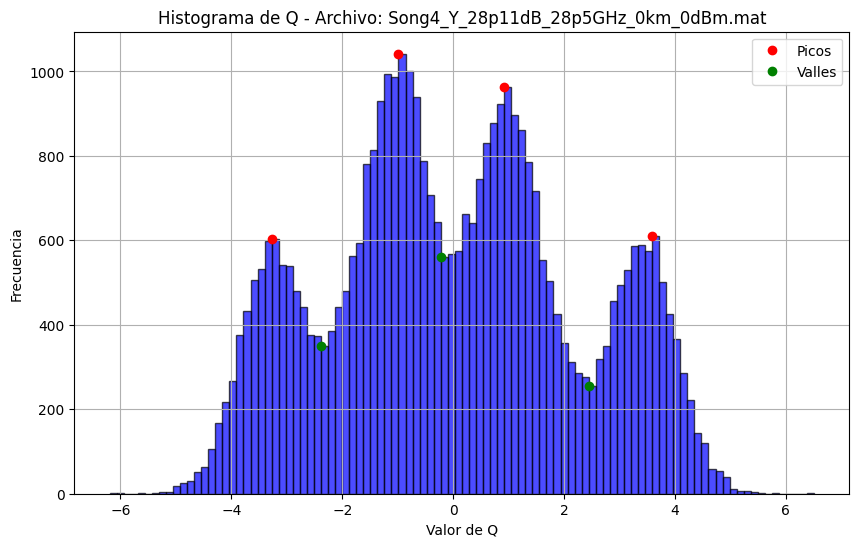

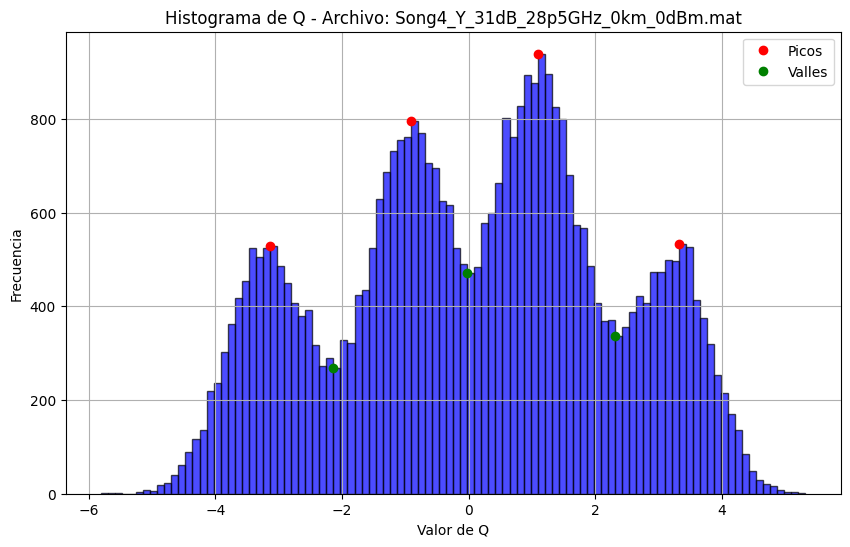

Archivo encontrado: Song4_Y_31dB_28p5GHz_0km_0dBm.mat


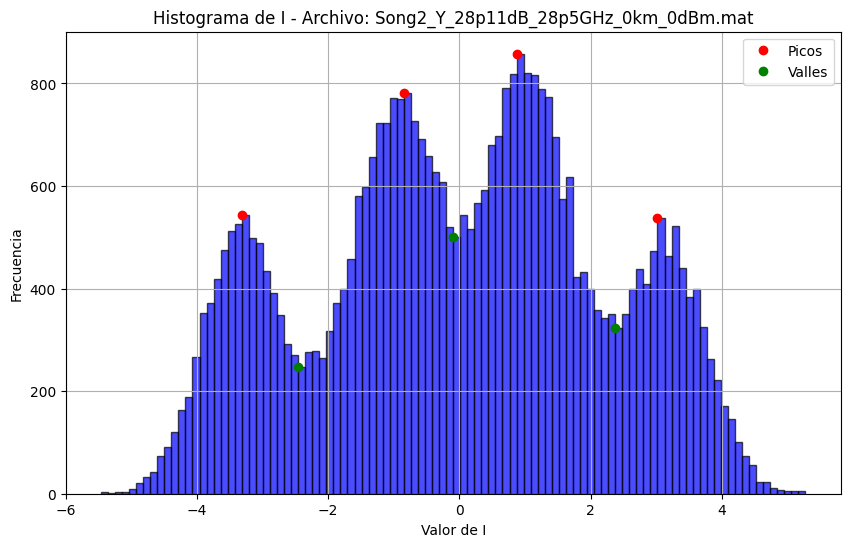

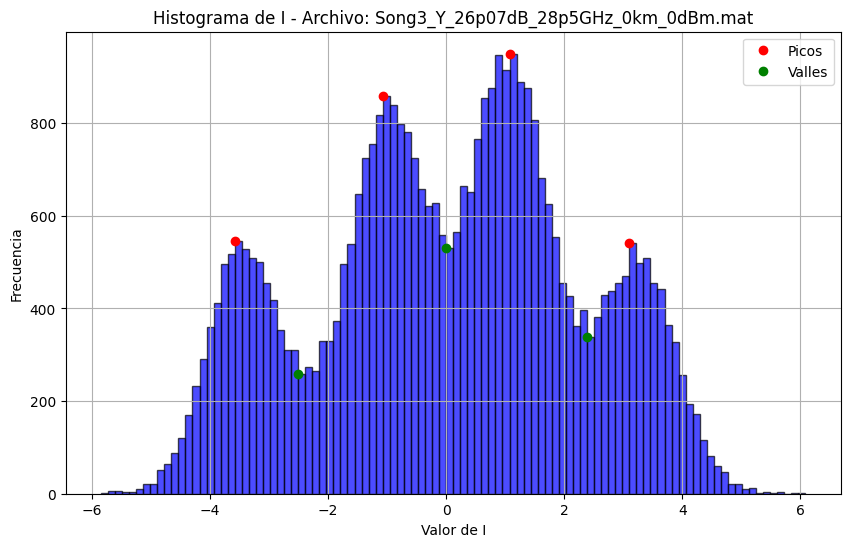

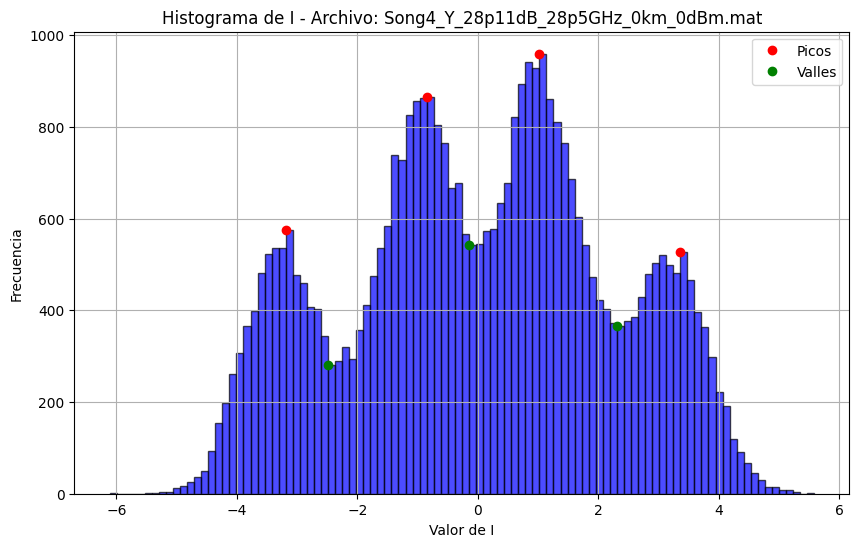

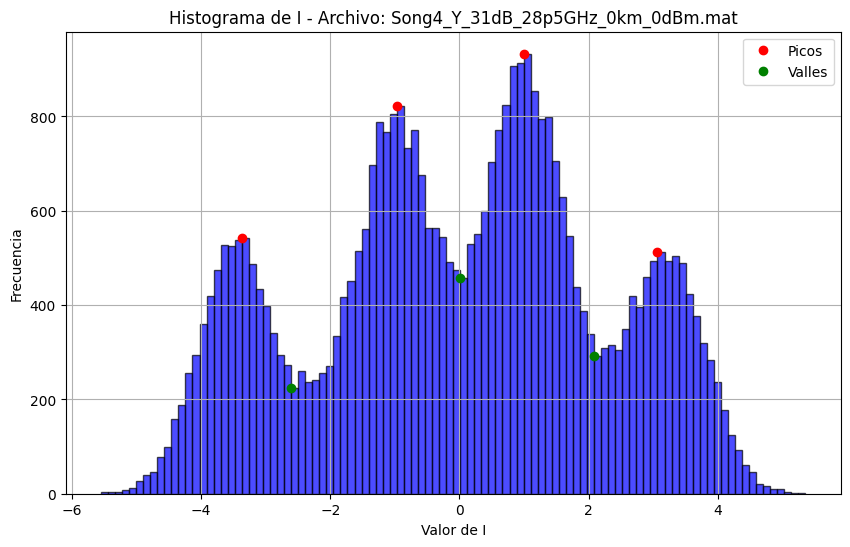

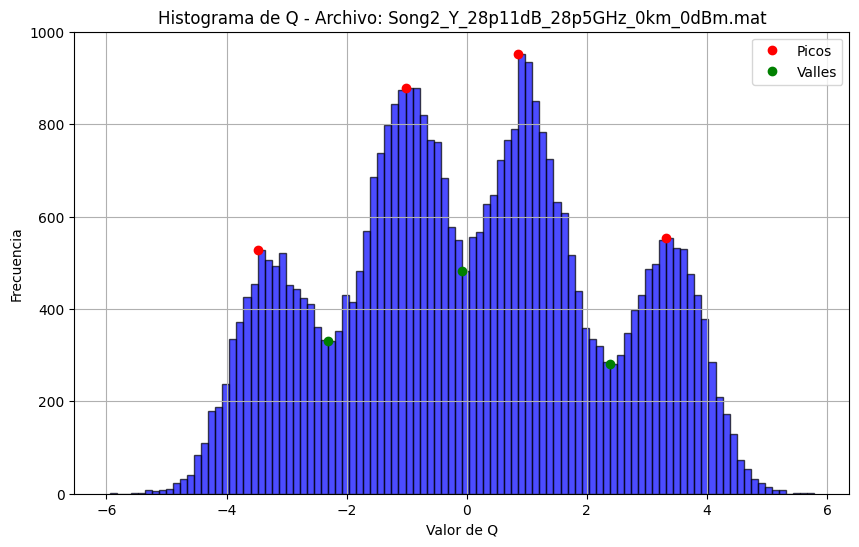

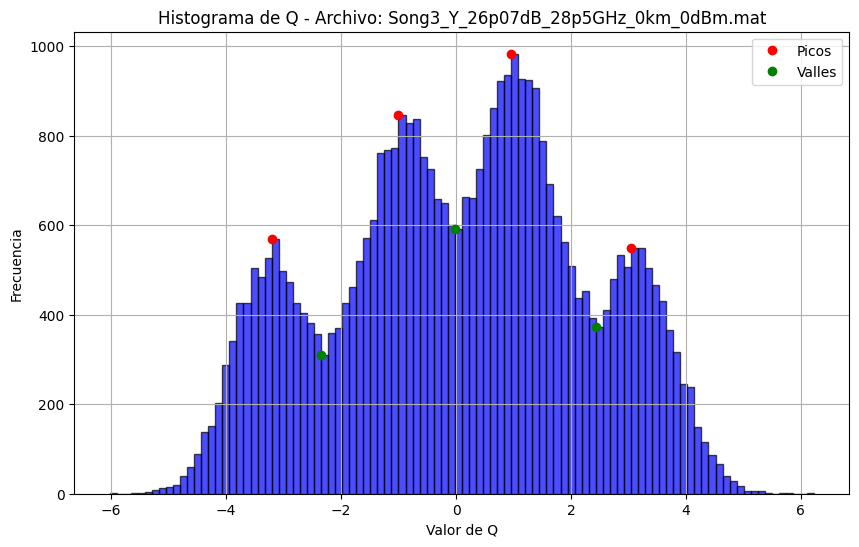

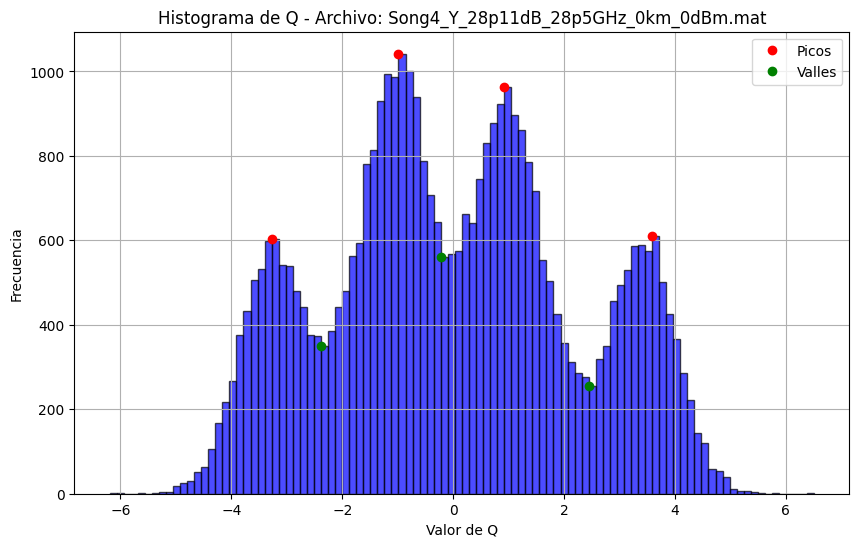

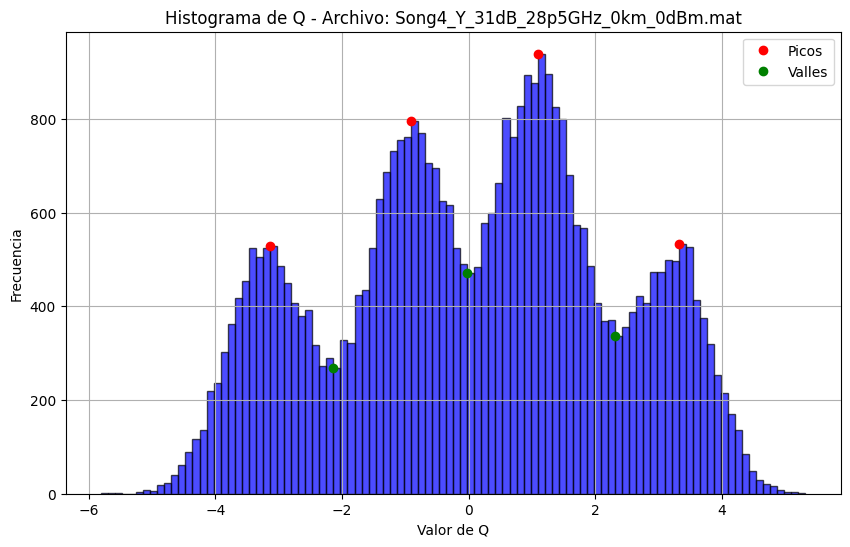

In [8]:
matriz_caract = analyze_data(data)

In [9]:
print(matriz_caract)

[[-3.31738697e+00 -8.46745708e-01  8.71961255e-01  3.02034496e+00
  -3.48374248e+00 -1.01981233e+00  8.57467793e-01  3.32139795e+00
  -2.45803349e+00 -9.48114114e-02  2.37582985e+00 -2.31044241e+00
  -8.11722660e-02  2.38275789e+00  1.07419185e+01  1.17330007e+01
   2.85000000e+01  2.81100000e+01]
 [-3.58395023e+00 -1.07679535e+00  1.07219455e+00  3.10179612e+00
  -3.20663919e+00 -1.00044772e+00  9.60611370e-01  3.04423665e+00
  -2.50945528e+00 -2.30039710e-03  2.38546616e+00 -2.34867584e+00
  -1.99181730e-02  2.43140568e+00  1.19388328e+01  1.22566193e+01
   2.85000000e+01  2.60700000e+01]
 [-3.18917568e+00 -8.50138896e-01  1.02109053e+00  3.36012732e+00
  -3.27264880e+00 -9.85243268e-01  9.20928006e-01  3.58956779e+00
  -2.48746465e+00 -1.48427860e-01  2.30756077e+00 -2.38310220e+00
  -2.22774758e-01  2.44586503e+00  1.16951839e+01  1.27078085e+01
   2.85000000e+01  2.81100000e+01]
 [-3.36948796e+00 -9.69884314e-01  9.93427756e-01  3.06581272e+00
  -3.13737164e+00 -9.11233586e-01  1.